

```
# This is formatted as code
```

#CNN ML Model on Skin Lesion Images for Melanoma Classification

## Group Members
1. Diniya Fakhriza Aulia Putri Zahra (2206820314)
2. Hasan Abdul Lathif (2206815503)
3. Josephine Sere Emmanuela Tamba (2206060706)

## Dataset Overview

Using HAM10000 (Human Against Machine with 10000) training images, defined as datasets used in machine learning models for skin lesion classificatoon (skin cancer types). The datasets will be categorized into 7 classes:
- nv: Melanocytic nevi
- mel: Melanoma
- bkl: Benign keratosis-like lesions
- bcc: Basal cell carcinoma
- akiec: Actinic keratoses
- vasc: Vascular lesions
- df: Dermatofibroma

The chosen dataset from Kaggle also consisted with the metadata file about informations in each images:
- image_id: Unique identifier for each image
- dx: Dermatologist's diagnosis
- age: Patient's age
- sex: Patient's sex
- localization: Body site of the lesion



# Install and Import Libraries

This first cell handles the complete setup. It installs all the necessary Python libraries for data handling, deep learning, and creating the GUI, then imports them into our environment.

In [ ]:
# Install libraries
!pip install -q streamlit pyngrok tensorflow pandas Pillow kagglehub seaborn

# Import libraries
import os
import pandas as pd
import numpy as np
import kagglehub
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import tensorflow as tf
from PIL import Image
from pyngrok import ngrok
import getpass

from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

# Data Loading and Initial Setup

This cell connects to Google Drive for permanent storage, downloads the HAM10000 dataset, and loads the metadata into a pandas DataFrame. It then enriches the DataFrame by mapping image paths to their corresponding metadata records.

In [ ]:
# Mount Google Drive to save models permanently
drive.mount('/content/drive')

# Define a folder in your Google Drive where models will be saved
project_folder = '/content/drive/My Drive/BSIP_Final_Project/'
os.makedirs(project_folder, exist_ok=True)
print(f"✅ Models will be saved to your Google Drive in: {project_folder}")

# Download the dataset using kagglehub
print("\nDownloading dataset...")
try:
    dataset_path = kagglehub.dataset_download('kmader/skin-cancer-mnist-ham10000')
    print(f"Dataset downloaded to: {dataset_path}")
except Exception as e:
    print(f"Error downloading dataset: {e}")
    # exit() # Use exit() in a real run to stop execution on failure

# Define paths and load metadata
metadata_file = os.path.join(dataset_path, 'HAM10000_metadata.csv')
images_dir_part1 = os.path.join(dataset_path, 'HAM10000_images_part_1')
images_dir_part2 = os.path.join(dataset_path, 'HAM10000_images_part_2')
all_image_files = glob.glob(os.path.join(images_dir_part1, '*.jpg')) + glob.glob(os.path.join(images_dir_part2, '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_files}

# Prepare DataFrame
metadata_df = pd.read_csv(metadata_file)
lesion_type_dict = {
    'nv': 'Melanocytic nevi', 'mel': 'Melanoma', 'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma', 'akiec': 'Actinic keratoses', 'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
metadata_df['path'] = metadata_df['image_id'].map(imageid_path_dict.get)
metadata_df['cell_type'] = metadata_df['dx'].map(lesion_type_dict.get)
metadata_df['cell_type_idx'] = pd.Categorical(metadata_df['cell_type']).codes
print("\nDataFrame enriched with image paths and class labels.")

# Data Cleaning
metadata_df['age'].fillna((metadata_df['age'].mean()), inplace=True)
print("Missing 'age' values filled with the mean.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Models will be saved to your Google Drive in: /content/drive/My Drive/BSIP_Final_Project/

Dataset downloaded to: /kaggle/input/skin-cancer-mnist-ham10000

DataFrame enriched with image paths and class labels.
Missing 'age' values filled with the mean.


<ipython-input-7-828741731>:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  metadata_df['age'].fillna((metadata_df['age'].mean()), inplace=True)


# Exploratory Data Analysis (EDA) & Cleaning


In this section, we inspect the dataset to understand its properties. We check for missing data, handle duplicates, and visualize the distribution of key features like lesion type, age, and location.


PART 3: EXPLORATORY DATA ANALYSIS (EDA) & CLEANING
--- Missing Value Analysis ---
lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

Missing 'age' values filled with the mean.
Verifying missing values after cleaning:
lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

--- Duplicate Entry Analysis ---
Number of duplicate rows: 0

--- Visualizing Data Distributions ---


<ipython-input-8-1027733790>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  metadata_df['age'].fillna((metadata_df['age'].mean()), inplace=True)
<ipython-input-8-1027733790>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y='cell_type', data=metadata_df, order=metadata_df['cell_type'].value_counts().index, palette='viridis')


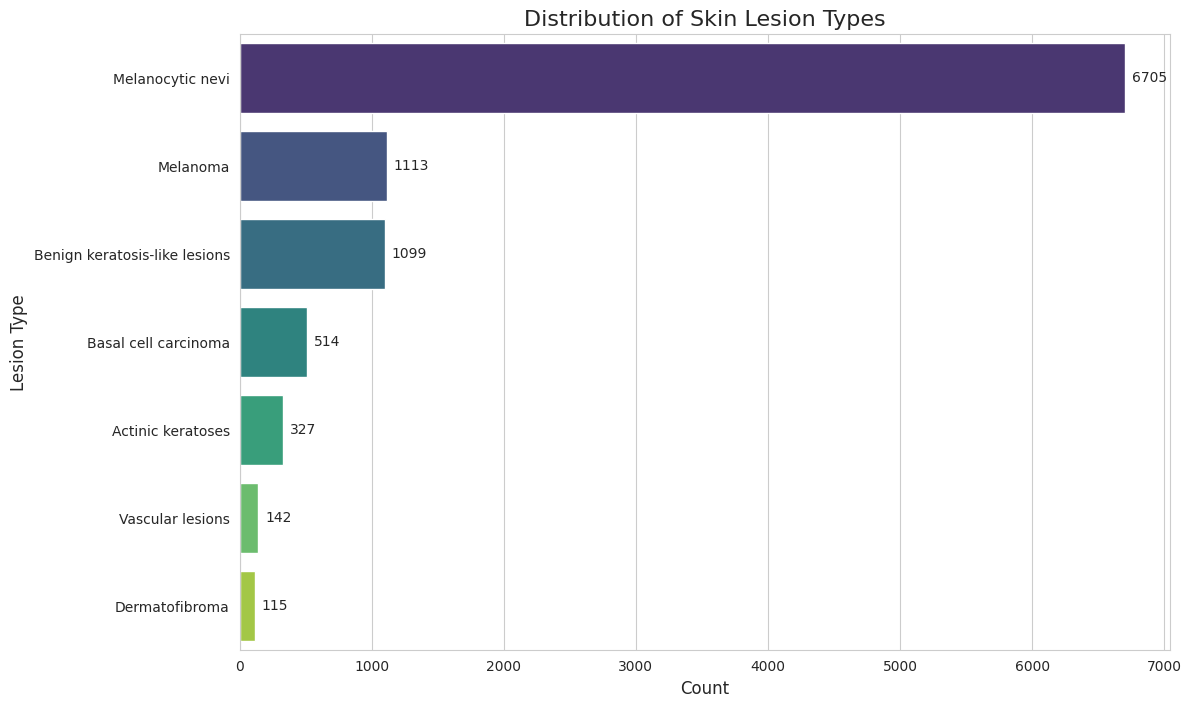

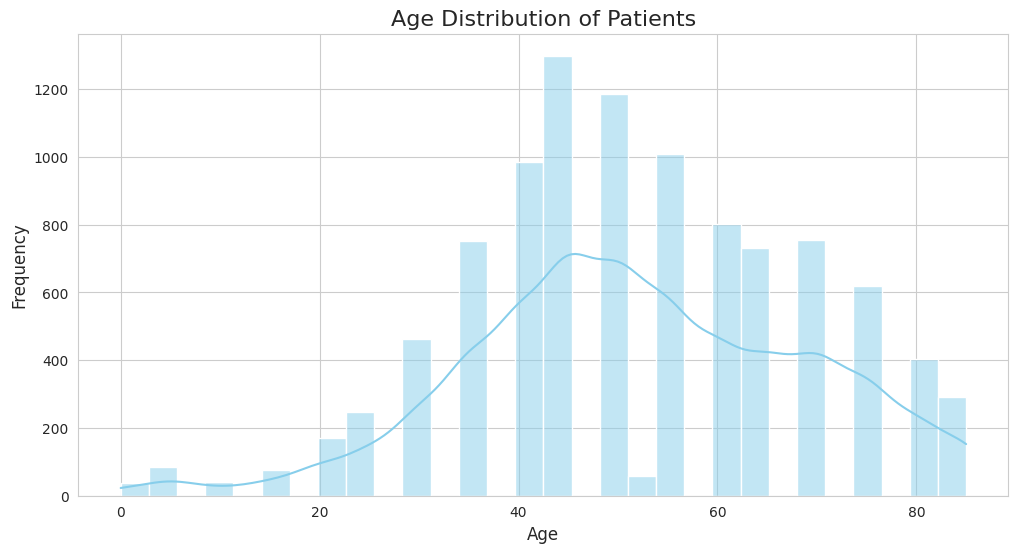


--- Visualizing Sample Images from Each Lesion Class ---


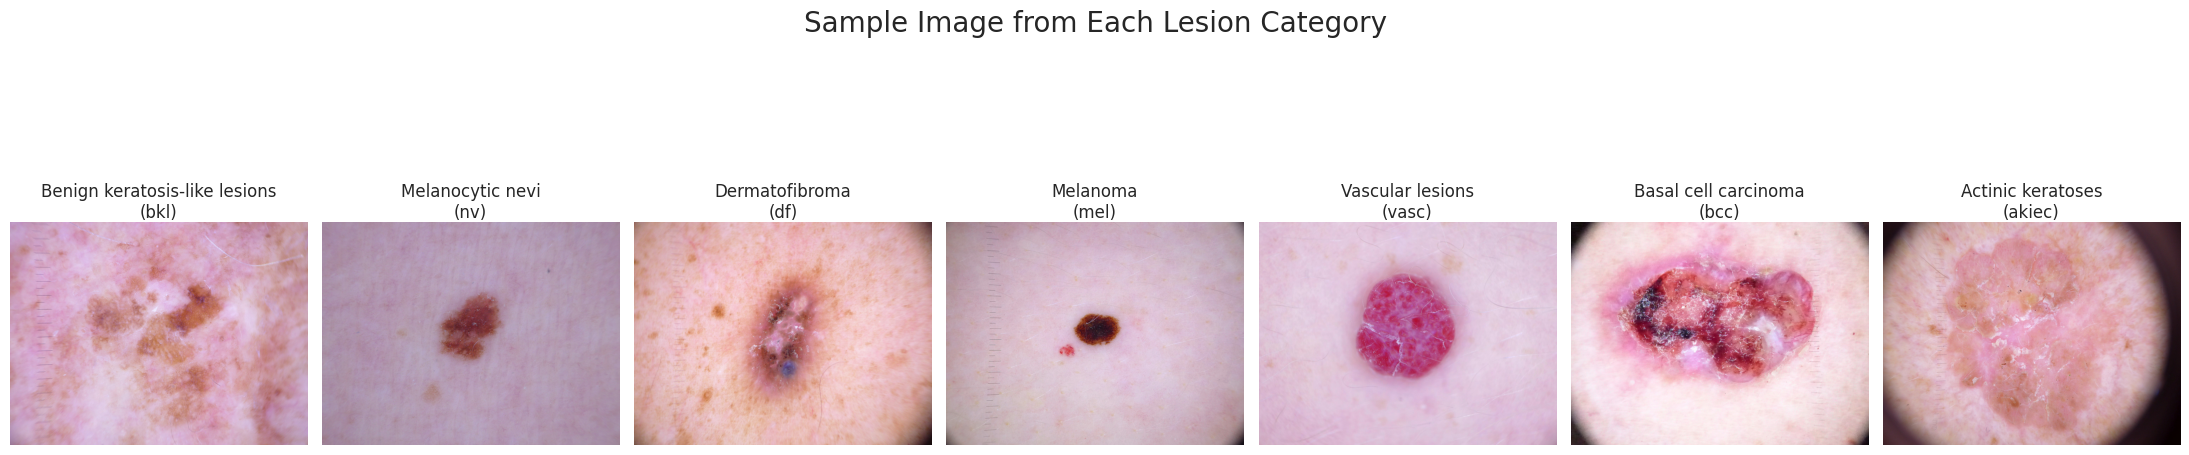

In [ ]:
print("\n" + "="*80)
print("PART 3: EXPLORATORY DATA ANALYSIS (EDA) & CLEANING")
print("="*80)

# --- Check for missing values ---
print("--- Missing Value Analysis ---")
print(metadata_df.isnull().sum())
# Fill missing age values with the mean
metadata_df['age'].fillna((metadata_df['age'].mean()), inplace=True)
print("\nMissing 'age' values filled with the mean.")
print("Verifying missing values after cleaning:")
print(metadata_df.isnull().sum())


# --- Check for duplicates ---
print("\n--- Duplicate Entry Analysis ---")
# The dataset has duplicate images for the same lesion but from different
# perspectives. For this project, we can keep them as they provide more
# varied training data. However, we'll check for duplicates based on
# all metadata to ensure there are no truly redundant rows.
print(f"Number of duplicate rows: {metadata_df.duplicated().sum()}")


# --- Visualize Data Distributions ---
print("\n--- Visualizing Data Distributions ---")

# Plot 1: Lesion Type Distribution (shows class imbalance)
plt.figure(figsize=(12, 8))
sns.set_style('whitegrid')
ax = sns.countplot(y='cell_type', data=metadata_df, order=metadata_df['cell_type'].value_counts().index, palette='viridis')
plt.title('Distribution of Skin Lesion Types', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Lesion Type', fontsize=12)
for container in ax.containers:
    ax.bar_label(container, padding=5)
plt.show()

# Plot 2: Age Distribution
plt.figure(figsize=(12, 6))
sns.histplot(metadata_df['age'], bins=30, kde=True, color='skyblue')
plt.title('Age Distribution of Patients', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# --- Visualize Sample Images ---
print("\n--- Visualizing Sample Images from Each Lesion Class ---")
# Get a mapping from the short code to the full name for titles
dx_to_cell_type = metadata_df.set_index('dx')['cell_type'].to_dict()
unique_dx = metadata_df['dx'].unique()

fig, axes = plt.subplots(1, len(unique_dx), figsize=(22, 6))
fig.suptitle('Sample Image from Each Lesion Category', fontsize=20)
for i, dx_code in enumerate(unique_dx):
    sample_row = metadata_df[metadata_df['dx'] == dx_code].iloc[0]
    img = Image.open(sample_row['path'])
    axes[i].imshow(img)
    axes[i].set_title(f"{dx_to_cell_type[dx_code]}\n({dx_code})", wrap=True, fontsize=12)
    axes[i].axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Data Splitting & Preprocessing

This cell splits the data into training, validation, and test sets. It then visualizes the effect of data augmentation, which will be used during training to create more robust models. Finally, it calculates the class weights that will be used to handle the dataset's class imbalance.



PART 4: DATA SPLITTING & PREPROCESSING
Data split into: 7010 training, 1502 validation, and 1503 test samples.

--- Visualizing Data Augmentation ---


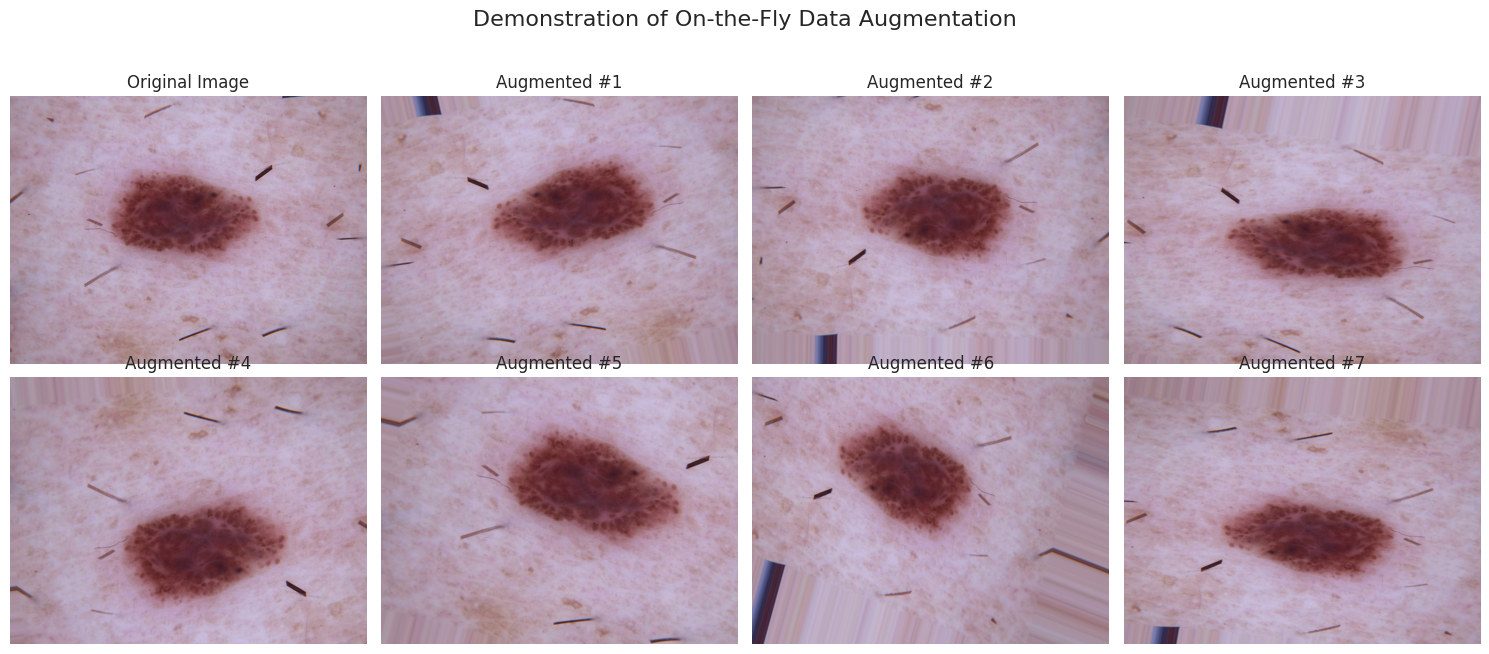


--- Calculating Class Weights for Model Training ---
Class weights calculated. The model will use these to pay more attention to minority classes.
{0: np.float64(4.37305053025577), 1: np.float64(2.7817460317460316), 2: np.float64(1.3022478172023035), 3: np.float64(12.36331569664903), 4: np.float64(0.21338772031292808), 5: np.float64(1.285530900421786), 6: np.float64(10.115440115440116)}


In [ ]:
print("\n" + "="*80)
print("PART 4: DATA SPLITTING & PREPROCESSING")
print("="*80)

# --- Split Data into Train, Validation, and Test Sets ---
model_df = metadata_df.dropna(subset=['path']).copy()
train_df, test_temp_df = train_test_split(
    model_df, test_size=0.30, random_state=1234, stratify=model_df['cell_type_idx']
)
validate_df, test_df = train_test_split(
    test_temp_df, test_size=0.50, random_state=1234, stratify=test_temp_df['cell_type_idx']
)
print(f"Data split into: {len(train_df)} training, {len(validate_df)} validation, and {len(test_df)} test samples.")

# --- Visualize Data Augmentation ---
print("\n--- Visualizing Data Augmentation ---")
# We define a generator with a wide range of transformations for demonstration.
datagen_visual = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

# Take one sample image to demonstrate the effect of augmentation
sample_img_path = train_df['path'].iloc[0]
img = load_img(sample_img_path)
img_array = img_to_array(img)
img_array = img_array.reshape((1,) + img_array.shape) # Reshape to a single-image "batch"

plt.figure(figsize=(15, 7))
plt.suptitle('Demonstration of On-the-Fly Data Augmentation', fontsize=16)

# Plot the original image first
plt.subplot(2, 4, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# Plot 7 augmented versions
i = 1
for batch in datagen_visual.flow(img_array, batch_size=1):
    plt.subplot(2, 4, i + 1)
    plt.imshow(batch[0])
    plt.title(f'Augmented #{i}')
    plt.axis('off')
    i += 1
    if i > 7: # We only need to show a few examples
        break
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Calculate Class Weights to handle imbalance ---
print("\n--- Calculating Class Weights for Model Training ---")
class_weights_dict = dict(enumerate(class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['cell_type_idx']),
    y=train_df['cell_type_idx']
)))
print("Class weights calculated. The model will use these to pay more attention to minority classes.")
print(class_weights_dict)

# Model Training

his cell defines, compiles, and trains both the baseline and advanced models. The `ImageDataGenerator` is used to create batches of augmented image data on-the-fly. Both models are trained using the class weights to ensure balanced learning.Finally, the trained models are saved permanently to Google Drive.


PART 5: MODEL TRAINING

--- 5A: Training the Baseline CNN Model ---
Found 7010 validated image filenames belonging to 7 classes.
Found 1502 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Baseline Model Architecture ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 75, 100, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 37, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 59200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,577,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,579,527 (28.91 MB)

 Trainable params: 7,579,527 (28.91 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.2442 - loss: 3.8478 - val_accuracy: 0.3848 - val_loss: 1.8455
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.3484 - loss: 1.9467 - val_accuracy: 0.5180 - val_loss: 1.4911
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.3665 - loss: 1.9114 - val_accuracy: 0.3529 - val_loss: 1.6540
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.3093 - loss: 1.9235 - val_accuracy: 0.4707 - val_loss: 1.6017
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.2524 - loss: 1.9241 - val_accuracy: 0.4627 - val_loss: 1.5514
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.3432 - loss: 1.9024 - val_accuracy: 0.5486 - val_loss: 1.4234
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.3483 - loss: 1.9550 - val_accuracy: 0.3542 - val_loss: 1.5986
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.3229 - loss: 1.8766 - val_accu

✅ Baseline model saved to your Google Drive!


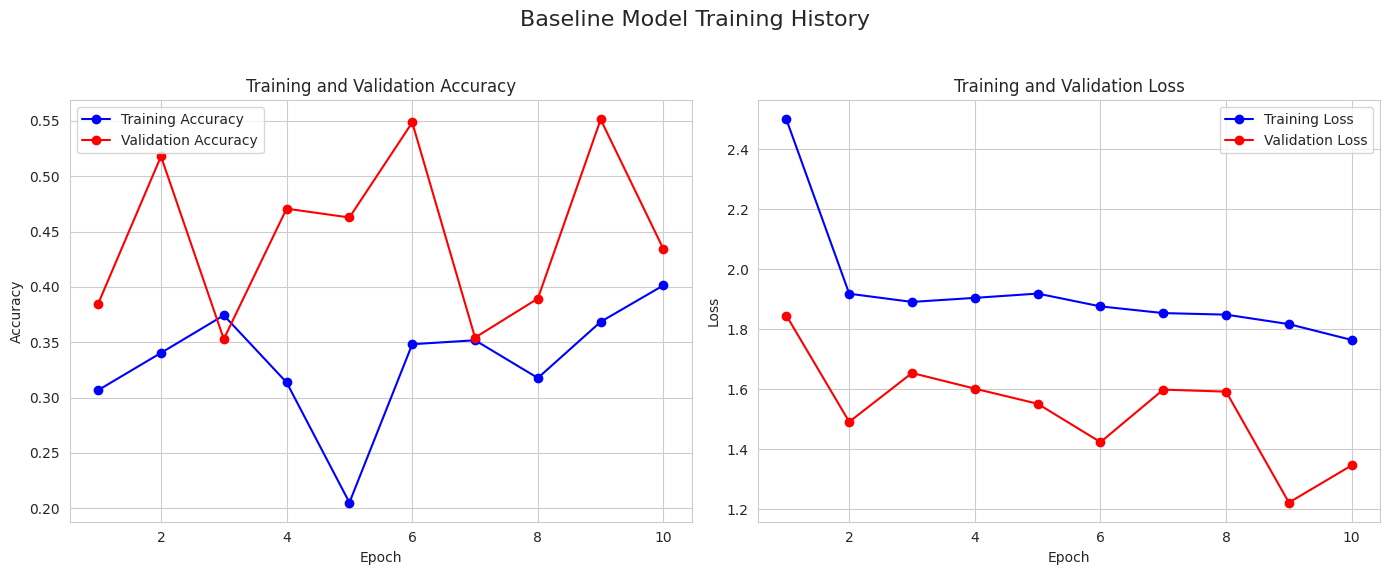


PART 5B: Training the DenseNet Model
Found 7010 validated image filenames belonging to 7 classes.
Found 1502 validated image filenames belonging to 7 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 7762s 70s/step - accuracy: 0.2892 - loss: 1.9035 - val_accuracy: 0.7344 - val_loss: 0.7627
Epoch 2/10
 23/110 ━━━━━━━━━━━━━━━━━━━━ 1:36:32 67s/step - accuracy: 0.5838 - loss: 0.9048

In [ ]:
print("\n" + "="*80)
print("PART 5: MODEL TRAINING")
print("="*80)

# --- Define Training History Plot Function ---
def plot_training_history(history, title):
    """
    Plots the training and validation accuracy and loss curves.
    """
    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 6))
    plt.suptitle(title, fontsize=16)

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- 5A: Train and Save the Baseline Model ---
print("\n--- 5A: Training the Baseline CNN Model ---")

IMG_SIZE_BASELINE = (100, 75)
BATCH_SIZE = 64
num_classes = 7

train_datagen_baseline = ImageDataGenerator(rescale=1./255., rotation_range=10, zoom_range=0.1)
val_datagen_baseline = ImageDataGenerator(rescale=1./255.)

train_generator_base = train_datagen_baseline.flow_from_dataframe(
    dataframe=train_df, x_col='path', y_col='cell_type',
    target_size=IMG_SIZE_BASELINE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True
)
validation_generator_base = val_datagen_baseline.flow_from_dataframe(
    dataframe=validate_df, x_col='path', y_col='cell_type',
    target_size=IMG_SIZE_BASELINE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

baseline_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='Same', input_shape=(75, 100, 3)),
    MaxPool2D(), Dropout(0.25), Flatten(), Dense(128, activation='relu'), Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
baseline_model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
print("\n--- Baseline Model Architecture ---")
baseline_model.summary()
history_base = baseline_model.fit(
    train_generator_base, epochs=10, validation_data=validation_generator_base,
    class_weight=class_weights_dict
)
baseline_model.save(os.path.join(project_folder, 'baseline_model.h5'))
print(f"✅ Baseline model saved to your Google Drive!")
plot_training_history(history_base, "Baseline Model Training History")


# --- 5B: Train and Save the DenseNet Model ---
print("\n" + "="*80)
print("PART 5B: Training the DenseNet Model")
print("="*80)

IMG_SIZE_DENSENET = (224, 224)
BATCH_SIZE = 64

train_datagen_densenet = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen_densenet = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator_densenet = train_datagen_densenet.flow_from_dataframe(
    dataframe=train_df, x_col='path', y_col='cell_type',
    target_size=IMG_SIZE_DENSENET, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True
)

validation_generator_densenet = val_datagen_densenet.flow_from_dataframe(
    dataframe=validate_df, x_col='path', y_col='cell_type',
    target_size=IMG_SIZE_DENSENET, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

# Initialize DenseNet121 model without the top layer
base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of DenseNet
x = base_model_densenet.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)  # num_classes is 7

# Create the final model
densenet_model = Model(inputs=base_model_densenet.input, outputs=predictions)

# Unfreeze some of the last layers for fine-tuning
for layer in base_model_densenet.layers[-10:]:  # Unfreeze last 10 layers
    layer.trainable = True

# Compile and train the model again
densenet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history_densenet = densenet_model.fit(
    train_generator_densenet, epochs=30, validation_data=validation_generator_densenet, class_weight=class_weights_dict
)

# Save the final fine-tuned model to Google Drive
densenet_model.save(os.path.join(project_folder, 'skin_cancer_densenet121_finetuned.h5'))
print(f"✅ Fine-tuned DenseNet121 model saved to your Google Drive!")

# Plot the DenseNet model training history
plot_training_history(history_densenet, "DenseNet Model Training History")

# Model Evaluation

This cell loads the trained models from Google Drive and evaluates their performance on the unseen test set. It generates a detailed classification report and a confusion matrix for each model, allowing for a direct comparison.


In [ ]:
print("\n" + "="*80)
print("PART 6: MODEL EVALUATION & COMPARISON")
print("="*80)

# --- Load Models from Google Drive ---
# It's good practice to load them fresh to ensure we're using the saved versions.
try:
    loaded_baseline_model = load_model(os.path.join(project_folder, 'baseline_model.h5'))
    loaded_densenet_model = load_model(os.path.join(project_folder, 'skin_cancer_densenet121_finetuned.h5'))
    print("✅ Successfully loaded both trained models from Google Drive.")
except Exception as e:
    print(f"❌ Error loading models: {e}")
    # In a real run, you might want to stop here if models can't be loaded.
    # For now, we'll continue assuming they loaded in the previous step.
    loaded_baseline_model = baseline_model
    loaded_densenet_model = densenet_model


# --- Create Test Data Generators ---
test_datagen_baseline = ImageDataGenerator(rescale=1./255.)
test_generator_base = test_datagen_baseline.flow_from_dataframe(
    dataframe=test_df, x_col='path', y_col='cell_type',
    target_size=IMG_SIZE_BASELINE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

test_datagen_densenet = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator_densenet = val_datagen_densenet.flow_from_dataframe(
    dataframe=test_df, x_col='path', y_col='cell_type',
    target_size=IMG_SIZE_DENSENET, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

# --- Get Predictions for Both Models ---
print("\nGenerating predictions from both models on the test set...")
y_pred_base = np.argmax(loaded_baseline_model.predict(test_generator_base), axis=1)
y_pred_densenet = np.argmax(loaded_densenet_model.predict(test_generator_densenet), axis=1)
y_true = test_generator_base.classes
class_names = list(test_generator_base.class_indices.keys())

# --- Display Classification Reports ---
print("\n" + "="*50 + "\n📊 CLASSIFICATION REPORT: BASELINE MODEL\n" + "="*50)
print(classification_report(y_true, y_pred_base, target_names=class_names))

print("\n" + "="*50 + "\n📊 CLASSIFICATION REPORT: DENSENET121 MODEL\n" + "="*50)
print(classification_report(y_true, y_pred_densenet, target_names=class_names))

# --- Visualize Confusion Matrices ---
def plot_confusion_matrix(cm, classes, title):
    """
    This function prints and plots the confusion matrix.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(title, size=16)
    plt.ylabel('True Label', size=13)
    plt.xlabel('Predicted Label', size=13)
    plt.tight_layout()
    plt.show()

print("\nGenerating confusion matrices...")
cm_base = confusion_matrix(y_true, y_pred_base)
plot_confusion_matrix(cm_base, classes=class_names, title='Baseline Model Confusion Matrix')

cm_densenet = confusion_matrix(y_true, y_pred_densenet)
plot_confusion_matrix(cm_densenet, classes=class_names, title='Fine-Tuned DenseNet121 Confusion Matrix')

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
print("\nComparing Models:\n")
print("Baseline CNN Accuracy: ", history_base.history['accuracy'][-1])
print("DenseNet121 Accuracy: ", history_densenet.history['accuracy'][-1])

# You can also compare loss values
print("Baseline CNN Loss: ", history_base.history['loss'][-1])
print("DenseNet121 Loss: ", history_densenet.history['loss'][-1])

# Launch Interactive GUI

This final cell writes the Streamlit application code to a file, then uses ngrok to create a secure public URL, allowing you to access and demonstrate your GUI from any web browser.

In [ ]:
print("\n" + "="*80)
print("PART 7: LAUNCHING THE INTERACTIVE GUI")
print("="*80)

# Copy the models from your Google Drive to the local Colab session
# The Streamlit app needs to find the files here.
!cp "{baseline_model_path}" .
!cp "{densenet_model_path}" .

print(f"\n✅ Models successfully copied from Google Drive to this session.")


# --- Step 4: Write the Streamlit App Code to app.py ---
print("--- Writing the Streamlit GUI code to app.py ---")

app_code = """
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image
import pandas as pd

# --- Page Configuration & Style ---
st.set_page_config(
    page_title="Klasifikasi Lesi Kulit",
    page_icon="🔬",
    layout="wide"
)

# --- Contextual Data Dictionary ---
lesion_info = {
    'Actinic keratoses': {'description': "Lesi pra-kanker yang disebabkan oleh paparan sinar UV.", 'risk': 'Tinggi', 'alert_level': 'warning'},
    'Basal cell carcinoma': {'description': "Jenis kanker kulit paling umum dan jarang menyebar.", 'risk': 'Tinggi', 'alert_level': 'warning'},
    'Benign keratosis-like lesions': {'description': "Pertumbuhan kulit non-kanker yang umum seiring usia.", 'risk': 'Rendah', 'alert_level': 'success'},
    'Dermatofibroma': {'description': "Benjolan kulit jinak yang umum di kaki bagian bawah.", 'risk': 'Rendah', 'alert_level': 'success'},
    'Melanocytic nevi': {'description': "Nama lain tahi lalat, sebagian besar tidak berbahaya.", 'risk': 'Rendah', 'alert_level': 'success'},
    'Melanoma': {'description': "Jenis kanker kulit paling serius karena kemampuannya menyebar.", 'risk': 'Sangat Tinggi', 'alert_level': 'error'},
    'Vascular lesions': {'description': "Kelainan kulit dari pembuluh darah, umumnya tidak berbahaya.", 'risk': 'Rendah', 'alert_level': 'success'}
}
class_names = list(lesion_info.keys())

# --- Model Loading ---
@st.cache_resource
def load_models():
    \"\"\"Loads both models from the locally copied .h5 files.\"\"\"
    try:
        densenet_model = tf.keras.models.load_model('skin_cancer_densenet121_finetuned.h5')
        baseline_model = tf.keras.models.load_model('baseline_model.h5')
        return {'DenseNet121 (Advanced)': densenet_model, 'Baseline CNN': baseline_model}
    except Exception as e:
        st.error(f"Critical error while loading models: {e}")
        st.error("Ensure 'baseline_model.h5' and 'skin_cancer_densenet121_finetuned.h5' are present in the session.")
        return None

models = load_models()

# --- Sidebar for Project Info ---
with st.sidebar:
    st.title("Project Details")
    st.info(
        '''
        **Course:** Biomedical Signal & Image Processing
        **Dataset:** HAM10000
        **Models:** Custom CNN vs. Fine-Tuned DenseNet121
        '''
    )
    st.warning("**Disclaimer:** This is a prediction tool, not a substitute for professional medical diagnosis.", icon="⚠️")

# --- Main Application Area ---
st.title("🔬 Klasifikasi Lesi Kulit (Skin Lesion Classification)")
st.markdown("Unggah gambar untuk membandingkan performa model CNN baseline dengan model DenseNet121 yang telah di-fine-tuning.")

upload_col, info_col = st.columns([1, 1])
with upload_col:
    uploaded_file = st.file_uploader(
        "Pilih atau jatuhkan gambar di sini (Choose or drop an image here)",
        type=["jpg", "jpeg", "png"],
        label_visibility="collapsed"
    )

if uploaded_file is None:
    info_col.info("Silakan unggah gambar untuk dianalisis (Please upload an image to analyze)...")
elif models is None:
    info_col.error("Models could not be loaded. Please check the file paths and try again.")
else:
    image = Image.open(uploaded_file).convert("RGB")
    upload_col.image(image, caption="Gambar yang akan dianalisis.", use_column_width=True)

    if info_col.button("🔬 Hasil Analisis (Analyze)", type="primary", use_container_width=True):
        with st.spinner("Model sedang menganalisis..."):
            # --- Baseline CNN Model Prediction ---
            img_base = image.resize((100, 75))
            arr_base = tf.keras.preprocessing.image.img_to_array(img_base) / 255.0
            pred_base = models['Baseline CNN'].predict(np.expand_dims(arr_base, axis=0))
            label_base = class_names[np.argmax(pred_base)]

            # --- DenseNet121 Model Prediction ---
            img_dense = image.resize((224, 224))
            arr_dense = tf.keras.preprocessing.image.img_to_array(img_dense)
            arr_dense_preprocessed = tf.keras.applications.densenet.preprocess_input(np.expand_dims(arr_dense, axis=0))
            pred_dense = models['DenseNet121 (Advanced)'].predict(arr_dense_preprocessed)
            # FIX: Corrected typo from np.argamax to np.argmax
            top_pred_index_dense = np.argmax(pred_dense)
            label_dense = class_names[top_pred_index_dense]
            info_dense = lesion_info[label_dense]

        st.markdown("---")
        st.subheader("Hasil Prediksi Model (Model Prediction Results)")

        res_col1, res_col2 = st.columns(2)
        with res_col1:
            st.metric(label="Baseline CNN Prediction", value=label_base)
        with res_col2:
            st.metric(label="DenseNet121 Advanced Prediction", value=label_dense)

        st.markdown("---")
        st.subheader("Analisis Detail (Model DenseNet121)")

        alert_level = info_dense['alert_level']
        alert_text = f"**Risiko Umum (General Risk):** {info_dense['risk']}. {info_dense['description']}"
        if alert_level == 'error': st.error(alert_text, icon="🚨")
        elif alert_level == 'warning': st.warning(alert_text, icon="⚠️")
        else: st.success(alert_text, icon="✅")

        st.bar_chart(pd.DataFrame({
            'Probabilitas (Probability)': pred_dense.flatten(),
            'Tipe Lesi (Lesion Type)': class_names
        }).set_index('Tipe Lesi (Lesion Type)'))
"""

# Write the Streamlit app code to a file
with open("app.py", "w") as f:
    f.write(app_code)
print("✅ Streamlit app script ('app.py') has been written.")

# --- Step 5: Authenticate and Run ngrok ---
print("\n--- Authenticating ngrok to launch GUI ---")
print("Please enter your ngrok authtoken to create a public link.")
print("You can get a free token from https://dashboard.ngrok.com/get-started/your-authtoken")
authtoken = getpass.getpass()

if authtoken:
    authtoken = authtoken.strip()

if not authtoken:
    print("❌ ERROR: ngrok authtoken is required.")
else:
    ngrok.set_auth_token(authtoken)
    print("✅ ngrok authtoken set!")

    # Terminate any existing tunnels to ensure a clean start
    ngrok.kill()

    # Set up a tunnel to Streamlit's default port (8501)
    public_url = ngrok.connect(8501)
    print(f"🚀 Your Streamlit App is live! Clickable Link: {public_url}")

    # Run the Streamlit app
    !streamlit run app.py --server.port 8501 --server.headless true


# Standalone GUI Code

In [ ]:
# --- Step 1: Install necessary libraries ---
!pip install -q streamlit pyngrok tensorflow pandas Pillow

# --- Step 2: Import Libraries ---
import os
import getpass
from google.colab import drive
from pyngrok import ngrok

# --- Step 3: Connect to Google Drive and Copy Models ---
print("--- Connecting to Google Drive to get saved models... ---")
drive.mount('/content/drive')

# Define the path to your project folder in Google Drive
project_folder = '/content/drive/My Drive/BSIP_Final_Project/'

# Define the paths for the model files
baseline_model_path = os.path.join(project_folder, 'baseline_model.h5')
densenet_model_path = os.path.join(project_folder, 'skin_cancer_densenet121_finetuned.h5')

# Copy the models from your Google Drive to the local Colab session
# The Streamlit app needs to find the files here.
!cp "{baseline_model_path}" .
!cp "{densenet_model_path}" .

print(f"\n✅ Models successfully copied from Google Drive to this session.")


# --- Step 4: Write the Streamlit App Code to app.py ---
print("--- Writing the Streamlit GUI code to app.py ---")

app_code = """
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image
import pandas as pd

# --- Page Configuration & Style ---
st.set_page_config(
    page_title="Klasifikasi Lesi Kulit",
    page_icon="🔬",
    layout="wide"
)

# --- Contextual Data Dictionary ---
lesion_info = {
    'Actinic keratoses': {'description': "Lesi pra-kanker yang disebabkan oleh paparan sinar UV.", 'risk': 'Tinggi', 'alert_level': 'warning'},
    'Basal cell carcinoma': {'description': "Jenis kanker kulit paling umum dan jarang menyebar.", 'risk': 'Tinggi', 'alert_level': 'warning'},
    'Benign keratosis-like lesions': {'description': "Pertumbuhan kulit non-kanker yang umum seiring usia.", 'risk': 'Rendah', 'alert_level': 'success'},
    'Dermatofibroma': {'description': "Benjolan kulit jinak yang umum di kaki bagian bawah.", 'risk': 'Rendah', 'alert_level': 'success'},
    'Melanocytic nevi': {'description': "Nama lain tahi lalat, sebagian besar tidak berbahaya.", 'risk': 'Rendah', 'alert_level': 'success'},
    'Melanoma': {'description': "Jenis kanker kulit paling serius karena kemampuannya menyebar.", 'risk': 'Sangat Tinggi', 'alert_level': 'error'},
    'Vascular lesions': {'description': "Kelainan kulit dari pembuluh darah, umumnya tidak berbahaya.", 'risk': 'Rendah', 'alert_level': 'success'}
}
class_names = list(lesion_info.keys())

# --- Model Loading ---
@st.cache_resource
def load_models():
    \"\"\"Loads both models from the locally copied .h5 files.\"\"\"
    try:
        densenet_model = tf.keras.models.load_model('skin_cancer_densenet121_finetuned.h5')
        baseline_model = tf.keras.models.load_model('baseline_model.h5')
        return {'DenseNet121 (Advanced)': densenet_model, 'Baseline CNN': baseline_model}
    except Exception as e:
        st.error(f"Critical error while loading models: {e}")
        st.error("Ensure 'baseline_model.h5' and 'skin_cancer_densenet121_finetuned.h5' are present in the session.")
        return None

models = load_models()

# --- Sidebar for Project Info ---
with st.sidebar:
    st.title("Project Details")
    st.info(
        '''
        **Course:** Biomedical Signal & Image Processing
        **Dataset:** HAM10000
        **Models:** Custom CNN vs. Fine-Tuned DenseNet121
        '''
    )
    st.warning("**Disclaimer:** This is a prediction tool, not a substitute for professional medical diagnosis.", icon="⚠️")

# --- Main Application Area ---
st.title("🔬 Klasifikasi Lesi Kulit (Skin Lesion Classification)")
st.markdown("Unggah gambar untuk membandingkan performa model CNN baseline dengan model DenseNet121 yang telah di-fine-tuning.")

upload_col, info_col = st.columns([1, 1])
with upload_col:
    uploaded_file = st.file_uploader(
        "Pilih atau jatuhkan gambar di sini (Choose or drop an image here)",
        type=["jpg", "jpeg", "png"],
        label_visibility="collapsed"
    )

if uploaded_file is None:
    info_col.info("Silakan unggah gambar untuk dianalisis (Please upload an image to analyze)...")
elif models is None:
    info_col.error("Models could not be loaded. Please check the file paths and try again.")
else:
    image = Image.open(uploaded_file).convert("RGB")
    upload_col.image(image, caption="Gambar yang akan dianalisis.", use_column_width=True)

    if info_col.button("🔬 Hasil Analisis (Analyze)", type="primary", use_container_width=True):
        with st.spinner("Model sedang menganalisis..."):
            # --- Baseline CNN Model Prediction ---
            img_base = image.resize((100, 75))
            arr_base = tf.keras.preprocessing.image.img_to_array(img_base) / 255.0
            pred_base = models['Baseline CNN'].predict(np.expand_dims(arr_base, axis=0))
            label_base = class_names[np.argmax(pred_base)]

            # --- DenseNet121 Model Prediction ---
            img_dense = image.resize((224, 224))
            arr_dense = tf.keras.preprocessing.image.img_to_array(img_dense)
            arr_dense_preprocessed = tf.keras.applications.densenet.preprocess_input(np.expand_dims(arr_dense, axis=0))
            pred_dense = models['DenseNet121 (Advanced)'].predict(arr_dense_preprocessed)
            # FIX: Corrected typo from np.argamax to np.argmax
            top_pred_index_dense = np.argmax(pred_dense)
            label_dense = class_names[top_pred_index_dense]
            info_dense = lesion_info[label_dense]

        st.markdown("---")
        st.subheader("Hasil Prediksi Model (Model Prediction Results)")

        res_col1, res_col2 = st.columns(2)
        with res_col1:
            st.metric(label="Baseline CNN Prediction", value=label_base)
        with res_col2:
            st.metric(label="DenseNet121 Advanced Prediction", value=label_dense)

        st.markdown("---")
        st.subheader("Analisis Detail (Model DenseNet121)")

        alert_level = info_dense['alert_level']
        alert_text = f"**Risiko Umum (General Risk):** {info_dense['risk']}. {info_dense['description']}"
        if alert_level == 'error': st.error(alert_text, icon="🚨")
        elif alert_level == 'warning': st.warning(alert_text, icon="⚠️")
        else: st.success(alert_text, icon="✅")

        st.bar_chart(pd.DataFrame({
            'Probabilitas (Probability)': pred_dense.flatten(),
            'Tipe Lesi (Lesion Type)': class_names
        }).set_index('Tipe Lesi (Lesion Type)'))
"""

# Write the Streamlit app code to a file
with open("app.py", "w") as f:
    f.write(app_code)
print("✅ Streamlit app script ('app.py') has been written.")

# --- Step 5: Authenticate and Run ngrok ---
print("\n--- Authenticating ngrok to launch GUI ---")
print("Please enter your ngrok authtoken to create a public link.")
print("You can get a free token from https://dashboard.ngrok.com/get-started/your-authtoken")
authtoken = getpass.getpass()

if authtoken:
    authtoken = authtoken.strip()

if not authtoken:
    print("❌ ERROR: ngrok authtoken is required.")
else:
    ngrok.set_auth_token(authtoken)
    print("✅ ngrok authtoken set!")

    # Terminate any existing tunnels to ensure a clean start
    ngrok.kill()

    # Set up a tunnel to Streamlit's default port (8501)
    public_url = ngrok.connect(8501)
    print(f"🚀 Your Streamlit App is live! Clickable Link: {public_url}")

    # Run the Streamlit app
    !streamlit run app.py --server.port 8501 --server.headless true


--- Connecting to Google Drive to get saved models... ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

✅ Models successfully copied from Google Drive to this session.
--- Writing the Streamlit GUI code to app.py ---
✅ Streamlit app script ('app.py') has been written.

--- Authenticating ngrok to launch GUI ---
Please enter your ngrok authtoken to create a public link.
You can get a free token from https://dashboard.ngrok.com/get-started/your-authtoken
··········
✅ ngrok authtoken set!
🚀 Your Streamlit App is live! Clickable Link: NgrokTunnel: "https://3abd-34-90-157-157.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.90.157.157:8501

2025-06-13 06:50:29.912042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT fac